In [8]:
from matplotlib import pyplot as plt
import os
import statistics
import time

import cirq
import numpy as np
import pandas as pd
import random
import pickle
from scipy.optimize import minimize
from util import generate_cost_matrix, draw_graph, generate_topology



node=3
p=0.66
n=node*node
num = n
matrix_penalty=n+1
depth =1
rep = 1000
factor = 1000
def load_graphs_from_pickle(file_name):
    with open(file_name, 'rb') as f:
        graphs = pickle.load(f)
    return graphs

r=1
[graph1,graph2] = load_graphs_from_pickle(f"dataset/graph_n{node}_p{p}_r{r}.pkl")

Q = generate_cost_matrix(graph1,graph2,penalty=0)

def process(cov_matrix,penalty,node):
    n=m=node
    k=node*node
    linear_coeffs = np.zeros(k)  # 初始化线性系数矩阵c
    constant_term = 2 * penalty * node  # 初始化常数项

    # 提取C部分的二次项系数
    quadratic_coeffs = np.copy(cov_matrix)

    # 提取lambda_1和lambda_2部分的二次项和线性项系数
    for i in range(n):
        for j in range(m):
            linear_coeffs[i * m + j] += -2 * penalty
            for k in range(m):
                quadratic_coeffs[i * m + j][i * m + k] += penalty

    for j in range(m):
        for i in range(n):
            linear_coeffs[j + i * m] += -2 * penalty
            for l in range(n):
                quadratic_coeffs[j + i * m][j + l * m] += penalty

    # 将矩阵变成下三角矩阵
    d = np.copy(np.diagonal(quadratic_coeffs))
    quadratic_coeffs += quadratic_coeffs.T

    quadratic_coeffs -= np.diag(d)

    quadratic_coeffs = np.tril(quadratic_coeffs)

    return quadratic_coeffs, linear_coeffs

quadratic_coeffs, linear_coeffs = process(Q,penalty=matrix_penalty,node=node)

def coef1(i,j):
    a = 1/2*quadratic_coeffs[i][j]
    return a
def coef2(n,i):
    a=linear_coeffs[i]
    for j in range(n):
        a += Q[i][j]
    return a

qubits = [cirq.GridQubit(0, i) for i in range(0, num)]


def xy_initialization(qubits):
    block_size = int(np.sqrt(len(qubits)))
    # 遍历每个块
    for i in range(block_size):
        yield cirq.X.on(qubits[i*block_size+i])


def create_circuit(params):
    # print(params)
    circuit = cirq.Circuit()
    # circuit.append(initialization(qubits))
    qubits_init = [cirq.GridQubit(0, i) for i in range(0, num)]
    circuit.append(xy_initialization(qubits_init))
    for d in range(0, depth):

        for i in range(0, num - 1):
            for j in range(i + 1, num):
                circuit += cirq.CNOT(qubits[i], qubits[j])
                circuit += cirq.rz(coef1(i, j) * params[int(2 * d)] * factor)(qubits[j])
                circuit += cirq.CNOT(qubits[i], qubits[j])
        for i in range(0, num):
            circuit += cirq.rz(coef2(n, i) * params[int(2 * d)] * factor)(qubits[i])

        for k in range(0,num):
             circuit+=cirq.rx(params[int(2*d+1)]*factor)(qubits[k])



    circuit.append(cirq.measure(*qubits, key='x'))
    simulator = cirq.Simulator()
    results = simulator.run(circuit, repetitions=rep)
    results = str(results)[2:].split(", ")
    newresult = []
    for i in range(0, rep):
        hold = []
        for j in range(0, num):
            hold.append(int(results[j][i]))
        newresult.append(hold)

    return newresult

def cost_function(params):
    gr = create_circuit(params)
    total_cost = 0
    for r in range(0, len(gr)):
        for i in range(n):
            for j in range(n):
                total_cost+=gr[r][i]*gr[r][j]*Q[i][j]
    total_cost = float(total_cost) / rep
    return total_cost


def verify(matrix):
    cov = matrix
    a = []
    for i in range(2 ** n):
        bb = bin(i)[2:]
        if len(bb) < n:
            bb = (n - len(bb)) * '0' + bb
        a.append(bb)
    h = []
    for i in a:
        if i.count("1") == node:
            h.append(i)
    b = h

    c = []
    for t in b:
        s1 = 0
        for i in range(n):
            for j in range(n):
                g = list(t)
                g[i] = int(g[i])
                g[j] = int(g[j])
                s1 += g[i] * Q[i][j] * g[j]
        c.append(s1)

    # 1. 找到最小的代价
    min_cost = min(c)

    # 2. 获取所有对应的解
    min_cost_solutions = []
    for idx, cost in enumerate(c):
        if cost == min_cost:
            min_cost_solutions.append(b[idx])

    # 输出最小代价及其对应的解集合
    print("最小代价:", min_cost)
    print("最小代价的解集合:", min_cost_solutions)
    return min_cost, min_cost_solutions


# f[r][i] 表示第 r 个近似解的第 i 个字符串
# min_cost_solutions[i] 表示第 i 个最优解的字符串
def compute_opt_gap(f, min_cost_solutions):
    n = len(f[0])  # 每个解的长度
    k = len(min_cost_solutions)  # 最优解集合的大小
    total_gap = 0.0  # 用于累加所有近似解的最优间隙

    # 遍历所有近似解
    for r in range(len(f)):
        min_gap = float(n)  # 初始化为一个很大的值

        # 对于每个近似解，遍历所有最优解
        for i in range(k):
            # 计算近似解 f[r] 与最优解 min_cost_solutions[i] 之间的 Hamming 距离
            distance = 0.0
            for j in range(n):
                if f[r][j] != int(min_cost_solutions[i][j]):
                    distance += 1
            # 计算 Hamming 距离的比例
            gap = float(distance / n)
            min_gap = min(min_gap, gap)  # 选择最小的间隙

        total_gap += min_gap  # 将每个近似解的最优间隙加到总和中
    # 计算所有近似解的平均最优间隙
    avg_opt_gap = float(total_gap / len(f))
    return avg_opt_gap

def landspace(k=10):
    # 定义gamma和beta的范围 (0 到 2π)
    gamma_vals = np.linspace(0, 2 * np.pi, k)
    beta_vals = np.linspace(0, 2 * np.pi, k)
    # 生成gamma-beta网格
    gamma_grid, beta_grid = np.meshgrid(gamma_vals, beta_vals)
    # 计算exp值
    exp_vals = np.zeros_like(gamma_grid)
    for i in range(k):
        for j in range(k):
            exp_vals[i, j] = cost_function([gamma_grid[i, j], beta_grid[i, j]])

    # 画图
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # 使用contourf进行平滑填充
    # c = ax.contourf(gamma_grid, beta_grid, exp_vals, levels=100, cmap='viridis')
    c = ax.pcolormesh(gamma_grid, beta_grid, exp_vals, shading='auto', cmap='viridis')
    
    # 添加颜色条
    plt.colorbar(c, label="Cost Function Value")

    # 设置坐标轴
    ax.set_xlabel(r"$\gamma$")
    ax.set_ylabel(r"$\beta$")
    ax.set_title("Cost Landscape")

    return


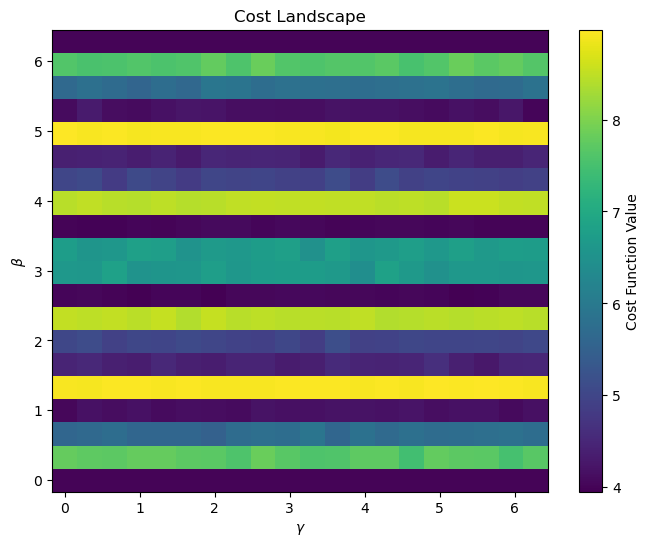

In [9]:
landspace(20)